# Implicit feedback recommender system
- https://github.com/benfred/implicit
- https://www.benfrederickson.com/matrix-factorization/
- https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
- https://kojinoshiba.com/recsys-cold-start/

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization
from implicit.approximate_als import (
    AnnoyAlternatingLeastSquares,
    FaissAlternatingLeastSquares,
    NMSLibAlternatingLeastSquares,
)
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px


# Data Exploration

In [2]:
# Read csv files
df = pd.read_csv('retail.csv')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [6]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
# Get df_events and correctly encode the variables
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],unit='ms')
df = df.astype({'CustomerID': object, 'StockCode': object})
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [8]:
df.rename(columns ={'InvoiceNo':'TransactionId', 'StockCode':'ItemId', 'InvoiceDate':'TransactionDate'},inplace=True)

In [9]:
# Describe dataset
df.describe(include='all', datetime_is_numeric=True)

,TransactionId,ItemId,Description,Quantity,TransactionDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.0,541909
unique,25900,4070,4223,NaN,NaN,NaN,4372.0,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,17841.0,United Kingdom
freq,1114,2313,2369,NaN,NaN,NaN,7983.0,495478
mean,NaN,NaN,NaN,9.552250,2011-07-04 13:34:57.156151552,4.611114,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,2010-12-01 08:26:00,-11062.060000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,2011-03-28 11:34:00,1.250000,NaN,NaN
50%,NaN,NaN,NaN,3.000000,2011-07-19 17:17:00,2.080000,NaN,NaN
75%,NaN,NaN,NaN,10.000000,2011-10-19 11:27:00,4.130000,NaN,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,38970.000000,NaN,NaN


In [10]:
# Percentage of missing values 
(df.isna().sum() / df.shape[0])* 100

TransactionId       0.000000
ItemId              0.000000
Description         0.268311
Quantity            0.000000
TransactionDate     0.000000
UnitPrice           0.000000
CustomerID         24.926694
Country             0.000000
dtype: float64

In [11]:
newCustomers_df = df[df.CustomerID.isna()]
newCustomers_df.head()

,TransactionId,ItemId,Description,Quantity,TransactionDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [12]:
df

,TransactionId,ItemId,Description,Quantity,TransactionDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


In [13]:
regularCustomers_df = df[~df.CustomerID.isna()]
regularCustomers_df

,TransactionId,ItemId,Description,Quantity,TransactionDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


In [14]:
regularCustomers_df.groupby("CustomerID")[['ItemId']].count() 

,ItemId
CustomerID,
12346.0,2
12347.0,182
12348.0,31
12349.0,73
12350.0,17
...,...
18280.0,10
18281.0,7
18282.0,13


# Reduce Sparsity

> **While implicit recommendations excel where data is sparse, it can often be helpful to make the interactions matrix a little more dense.**

- To reduce sparsity we can exclude users or/and items without significant event history ([cold-start problem](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems)))
- We limited our dataset to users and items with at least 5 event occurrences.

In [15]:
def threshold_ratings(df, uid_min, iid_min, max_iter=None):
    """Removes users and items with less than uid_min and iid_min event occurrences, respectively.
    Credits: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    n_users = df['CustomerID'].nunique()
    n_items = df['ItemId'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Raw dataset info \n-----------------')
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        # When we exclude users with freq less than uid_min we might end up with new 
        # items with freq less than iid_min, so we will have to alternate back and forth
        starting_shape = df.shape[0]  # number of existing events

        uid_counts = df.groupby('CustomerID').size()  # user id frequencies
        df = df[~df['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  # keep events with users with frequency >= uid_min

        iid_counts = df.groupby('ItemId').size()  # item id frequencies
        df = df[~df['ItemId'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  # keep events with items with frequency >= iid_min

        ending_shape = df.shape[0]  # number of existing events after filters
        i += 1
        if starting_shape == ending_shape or i == max_iter:  # convergence happens
            done = True
    
    if not max_iter:
        assert(df.groupby('CustomerID').size().min() >= uid_min)
        assert(df.groupby('ItemId').size().min() >= iid_min)
    
    n_users = df['CustomerID'].nunique()
    n_items = df['ItemId'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Limited dataset info \n-----------------')
    print('Number of iterations until convergence: {}'.format(i))
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [48]:
# get limited dataset
df_limited = threshold_ratings(regularCustomers_df, 10, 5)

Raw dataset info 
-----------------
Number of users: 4372
Number of items: 3684
Sparsity: 2.526%
Limited dataset info 
-----------------
Number of iterations until convergence: 2
Number of users: 3781
Number of items: 3205
Sparsity: 3.324%


# Train-test split
We want to split the train and test events such that:
- all test events occur after all train events

In [52]:
# Train-test split
start_train = df_limited['TransactionDate'].min()
start_test = start_train + pd.to_timedelta(23, unit='w')
end_test = start_test + pd.to_timedelta(5, unit='w')

# Create new limited df
df_limited = df_limited.loc[(df_limited['TransactionDate'] > start_train) & (df_limited['TransactionDate'] <= end_test)]

# Create train_split flag
df_limited['train_split'] = (df_limited['TransactionDate'] <= start_test).astype(int)
print("Proportion of train events: {:.2f}".format(df_limited['train_split'].mean()))

Proportion of train events: 0.79


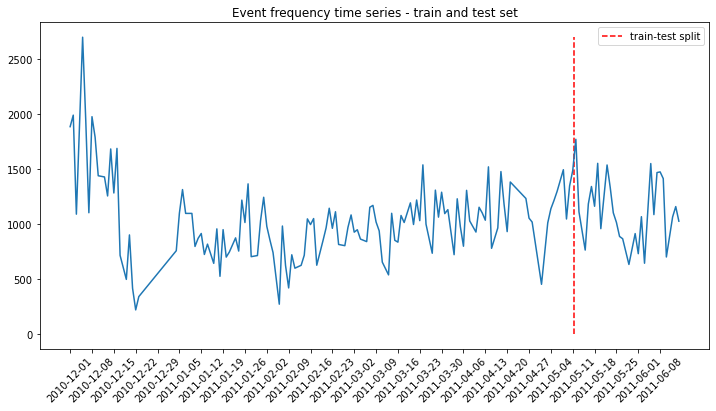

In [53]:
# Visualize train and test set
data = pd.DatetimeIndex(df_limited['TransactionDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.vlines(start_test, 0, data.max(), linestyles='dashed', color='r', label='train-test split')
plt.legend()
plt.title('Event frequency time series - train and test set')
plt.show()

# Create the train and test Rating Matrices

<img src="./images/MaskTrain.png" alt="MaskTrain" style="width: 600px;"/>

In [54]:
# the Categoricals data structure consists of a categories array and an integer array of codes which point to 
#    the real value in the categories array
user_cat = df_limited['CustomerID'].astype('category')
item_cat = df_limited['ItemId'].astype("category")

# create a sparse matrix of all the item/user/counts triples for the train set and test set
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix
item_user_train = coo_matrix((df_limited['train_split'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()
item_user_train.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_train
user_item_train = item_user_train.T

item_user_test = coo_matrix(((~df_limited['train_split'].astype(bool)).astype(int),
                             (item_cat.cat.codes,
                              user_cat.cat.codes))).tocsr()
item_user_test.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_test
user_item_test = item_user_test.T

# map each item and user category to a unique numeric code
user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

# confirm shapes
print(f"train set shape: {item_user_train.shape} and test set shape: {item_user_test.shape}")

# check sparsity
pzeros_train = 100 * (1 - item_user_train.count_nonzero() / (item_user_train.shape[0] * item_user_train.shape[1]))
pzeros_test = 100 * (1 - item_user_test.count_nonzero() / (item_user_test.shape[0] * item_user_test.shape[1]))
print(f"train set percentage of zeros: {pzeros_train} and test set percentage of zeros: {pzeros_test}")

train set shape: (2873, 2553) and test set shape: (2873, 2553)
train set percentage of zeros: 98.6491326448045 and test set percentage of zeros: 99.59311602042274


In [55]:
# users with no items on the train set and not items on the test set
zero_users_test = (np.squeeze(np.asarray(user_item_test.sum(axis=1))) == 0).nonzero()[0]
zero_users_train = (np.squeeze(np.asarray(user_item_train.sum(axis=1))) == 0).nonzero()[0]
set(zero_users_test).intersection(zero_users_train)

set()

In [56]:
# most frequent user, item pair in train set
item_id, user_id = np.unravel_index(item_user_train.argmax(), item_user_train.shape)
item_id, user_id = get_keys(item_id, item_map), get_keys(user_id, user_map)
df_limited.loc[(df_limited['CustomerID'] == user_id) & (df_limited['ItemId'] == item_id) & (df_limited['train_split'] == 1)]

,TransactionId,ItemId,Description,Quantity,TransactionDate,UnitPrice,CustomerID,Country,train_split
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.0,14911,EIRE,1
12119,537368,C2,CARRIAGE,1,2010-12-06 12:40:00,50.0,14911,EIRE,1
12452,537378,C2,CARRIAGE,1,2010-12-06 13:06:00,50.0,14911,EIRE,1
37644,539473,C2,CARRIAGE,1,2010-12-19 14:24:00,50.0,14911,EIRE,1
42332,539984,C2,CARRIAGE,1,2010-12-23 14:58:00,50.0,14911,EIRE,1
44302,C540164,C2,CARRIAGE,-1,2011-01-05 12:02:00,50.0,14911,EIRE,1
50141,540547,C2,CARRIAGE,1,2011-01-09 16:07:00,50.0,14911,EIRE,1
61634,541434,C2,CARRIAGE,1,2011-01-18 10:22:00,50.0,14911,EIRE,1
69721,541979,C2,CARRIAGE,1,2011-01-24 14:54:00,50.0,14911,EIRE,1
73067,542278,C2,CARRIAGE,1,2011-01-27 10:43:00,50.0,14911,EIRE,1


### Fit the ALS model


In [57]:
# initialize a model
alpha = 40  # as we observe more evidence for positive preference, our confidence in pui = 1 increases according to alpha (rate of increase)
als_model = AlternatingLeastSquares(factors=100, regularization=0.03, iterations=100, random_state=0)


# train the model on a sparse matrix of item/user/confidence weights
# os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
# about the alpha hyperparameter: https://github.com/benfred/implicit/issues/199#issuecomment-490350326
als_model.fit((item_user_train * alpha).astype('double'))

# ALS model methods

In [58]:
# recommend items for a user. 
# the recommended items have the largest inner product with the user vector
user_id = list(user_map.keys())[0]
recommendations = als_model.recommend(user_map[user_id], user_item_train)
list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))

[('21790', 1.2948472),
 ('22907', 1.1056094),
 ('22692', 1.0253055),
 ('21756', 1.0081677),
 ('22961', 1.0030694),
 ('22745', 1.0001909),
 ('22720', 0.99848074),
 ('21901', 0.9937698),
 ('21755', 0.993747),
 ('23182', 0.99348795)]

In [59]:
als_model.recommend(user_map[user_id], user_item_train)

[(722, 1.2948472),
 (1664, 1.1056094),
 (1461, 1.0253055),
 (707, 1.0081677),
 (1716, 1.0030694),
 (1513, 1.0001909),
 (1489, 0.99848074),
 (794, 0.9937698),
 (706, 0.993747),
 (1896, 0.99348795)]

In [60]:
# find related items
# the related items have the largest inner product with the item vector
item_id = list(item_map.keys())[0]
related = als_model.similar_items(item_map[item_id])
list(map(lambda x: (get_keys(x[0], item_map), x[1]), related))

[('21756', 1.0000001),
 ('21754', 0.7457354),
 ('21755', 0.6776444),
 ('22120', 0.5801673),
 ('22119', 0.30383712),
 ('21226', 0.28389257),
 ('22233', 0.26120818),
 ('21179', 0.2556396),
 ('22478', 0.25181335),
 ('90209B', 0.24973042)]

In [61]:
# show the top 10 items that explain the recommended item to the user
# It is possible to write the LVM as a linear function between preferences and past actions.
# We can then see what are the actions associated with the highest contributions to the given recommendation.
score, contributions, user_weights = als_model.explain(user_map[user_id], 
                                                       user_item_train,
                                                       item_map[item_id])
print("The score of the user/item pair is: ", score)
print("The top N (itemid, score) contributions for this user/item pair are:\n", list(map(lambda x: (get_keys(x[0], item_map), x[1]), contributions)))

The score of the user/item pair is:  0.5412416212261453
The top N (itemid, score) contributions for this user/item pair are:
 [('21756', 0.1812737406429675), ('21754', 0.10616464127772754), ('21755', 0.09593715676580347), ('22969', 0.014105382789486837), ('22766', 0.013516564613519045), ('22960', 0.012314007364841555), ('48184', 0.012093649695392342), ('85123A', 0.009636487084686405), ('21621', 0.009576577722844572), ('22077', 0.00908447531507385)]


##  BayesianPersonalizedRanking Model

In [62]:
bpr_model = BayesianPersonalizedRanking()

In [63]:
bpr_model.fit(user_item_train)

## LogisticMatrixFactorization model

In [64]:
lmf_model = LogisticMatrixFactorization()

In [65]:
lmf_model.fit(user_item_train)

100%|██████████| 30/30 [00:00<00:00, 108.59it/s]


# Evaluation
**Note**: We are measuring how well the model will rank the items in the test set for a user, given different items in the training set i.e. **the train and test set have the same users**. We are not making inference for new users that didn't appear in the training set. For new users in production, there is a `recalculate_user` method which can be used for generating recommendations without recalculating the whole model. Also, the `recommend(recalculate_user=True)` method allows the model to recommend for new users on the fly ([github issue](https://github.com/benfred/implicit/issues/152)).

In [66]:
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [67]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(item_user_train)

In [68]:
# Evaluate models. 
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 
               'als_model': als_model,
                'bpr_model':bpr_model,
                'lmf_model':lmf_model,
              }
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, user_item_train, user_item_test, K=10, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model,als_model,bpr_model,lmf_model
precision,0.112384,0.057587,0.007871,0.008668
map,0.050706,0.021954,0.002002,0.002096
ndcg,0.115400,0.056224,0.006853,0.007221
auc,0.522603,0.511472,0.499579,0.499393


In [34]:
def recommend_items(model, userId):
    numberTrans=list(df[df['CustomerID']==userId].groupby('CustomerID')['TransactionId'].count())[0]
    if numberTrans < 11:
        print('Less than 10 Transactions, Popular Algorithm used')
        return pop_model.recommend(user_map[user_id],user_item_train)
    else:
        recommendations=model.recommend(user_map[user_id],user_item_train)
        return list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))

In [35]:
recommend_items(als_model, 12580)

[('22834', 1.2668427),
 ('15056N', 1.1820033),
 ('22867', 1.1316863),
 ('22865', 1.0880606),
 ('22837', 1.0619917),
 ('21871', 1.0043011),
 ('85123A', 1.0028126),
 ('84029E', 1.0027697),
 ('82486', 1.0016932),
 ('82494L', 1.0016226)]